In [2]:
# flower_photo 디렉토리 밑에 daisy, dandelion, roses, sunflowers, tulips 디렉토리 존재, 약 3670개 사진
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import os
import pathlib
import urllib.request
import tarfile

In [26]:
# 데이터 다운로드 함수
def download_and_extract_data():
    # 데이터 URL
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

    # 다운로드할 디렉토리 생성
    download_dir = os.path.join(os.getcwd(), 'flower_dataset')
    os.makedirs(download_dir, exist_ok=True)

    # 파일 다운로드
    tgz_path = os.path.join(download_dir, "flower_photos.tgz")

    if not os.path.exists(tgz_path):
        print("데이터셋 다운로드 중...")
        urllib.request.urlretrieve(dataset_url, tgz_path)
        print("다운로드 완료!")

    # 압축 해제
    if not os.path.exists(os.path.join(download_dir, "flower_photos")):
        print("압축 해제 중...")
        with tarfile.open(tgz_path) as tar:
            tar.extractall(path=download_dir)
        print("압축 해제 완료!")

    return os.path.join(download_dir, "flower_photos")

In [27]:
# 데이터 다운로드 및 경로 설정
data_dir = download_and_extract_data()
data_dir = pathlib.Path(data_dir)

In [28]:
# 클래스 및 이미지 개수 확인
classes = sorted([item.name for item in data_dir.glob('*/') if item.is_dir()])
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"발견된 클래스 : {classes}")
print(f"총 이미지 개수 : {image_count}")

발견된 클래스 : ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
총 이미지 개수 : 3670


In [29]:
# 각 클래스별 이미지 개수 확인
for class_name in classes:
    class_images = len(list(data_dir.glob(f'{class_name}/*')))
    print(f"{class_name} : {class_images}개 이미지")

daisy : 633개 이미지
dandelion : 898개 이미지
roses : 641개 이미지
sunflowers : 699개 이미지
tulips : 799개 이미지


In [30]:
# 이미지 크기 및 배치 크기 설정
img_height = 180
img_width = 180
batch_size = 32

In [31]:
# 훈련 데이터셋 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [32]:
# 검증 데이터셋 생성
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [33]:
# 클래스 이름 확인
class_names = train_ds.class_names
print("클래스 : ", class_names)
num_classes = len(class_names)

클래스 :  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [34]:
# 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [36]:
# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

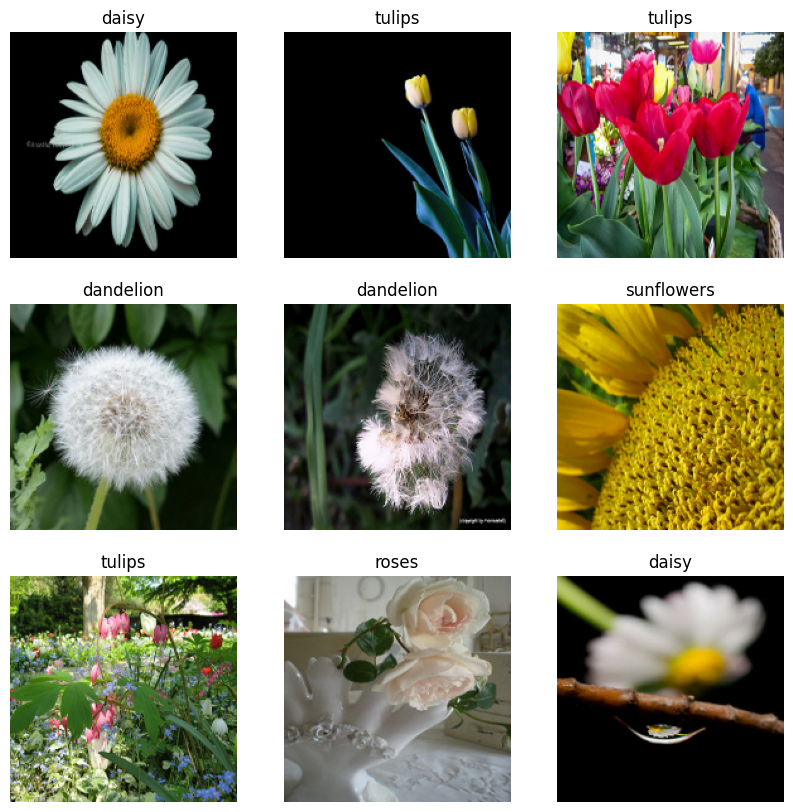

In [39]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [38]:
# CNN 모델 구성
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

c:\aiproject2\.venv\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
# 모델 컴파일
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [41]:
# 모델 구조 출력
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Early Stopping 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 3,
        restore_best_weights = True
    )
]

In [43]:
# 모델 학습
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.3430 - loss: 1.4955 - val_accuracy: 0.5668 - val_loss: 1.1012
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.5350 - loss: 1.1286 - val_accuracy: 0.5817 - val_loss: 1.0071
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.6062 - loss: 0.9888 - val_accuracy: 0.6267 - val_loss: 0.9855
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.6542 - loss: 0.9127 - val_accuracy: 0.6117 - val_loss: 1.0199
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.6482 - loss: 0.9134 - val_accuracy: 0.6649 - val_loss: 0.8863
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.6635 - loss: 0.8249 - val_accuracy: 0.6826 - val_loss: 0.8096
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.6884 - loss: 0.8118 - val_accuracy: 0.6744 - val_loss: 0.8009
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.6982 - loss: 0.7813 - val_accu

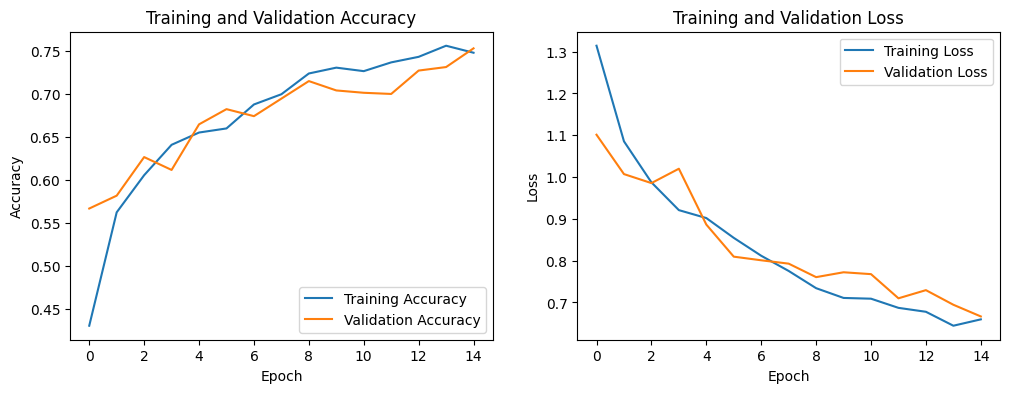

In [45]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [47]:
#  모델 저장
model.save('./model/flower_classification_model.h5')
print("모델이 'flower_classification_model.h5'로 저장되었습니다.")

모델이 'flower_classification_model.h5'로 저장되었습니다.


In [48]:
# 저장된 모델 불러오기
from tensorflow.keras.models import load_model

In [49]:
model_path = './model/flower_classification_model.h5'   # 저장된 모델 경로
loaded_model = load_model(model_path)
print("저장된 모델이 성공적으로 로드되었습니다.")

저장된 모델이 성공적으로 로드되었습니다.


In [52]:
# 저장된 모델을 활용한 이미지 예측 함수
def predict_flower_with_loaded_model(img_path, model, class_names):
    """
    이미지 경로와 모델을 입력박아 예측 결과를 출력하고 이미지를 시각화하는 함수
    
    Parameters:
        img_path(str) : 예측할 이미지 경로
        model(tf.keras.Model) : 저장된 모델
        class_names(list) : 클래스 이름 리스트
    """
    

    # 이미지 로드 및 전처리
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size = (img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)    # 배치 자원 추가

    # 예측 수행
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # 예측 결과 출력
    print(
        "이 이미지는 '{}' ({:.2f}% 확률) 입니다."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    # 이미지 시각화
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [65]:
# 테스트 이미지 경로
test_image_path = './flower_dataset/flower_photos/daisy/19544831049_0d738d4872_m.jpg'
# test_image_path = './flower_dataset/flower_photos/roses/12240303_80d87f77a3_n.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
이 이미지는 'daisy' (40.46% 확률) 입니다.


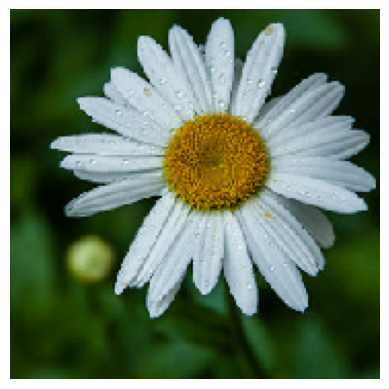

In [66]:
# 예측 실행
predict_flower_with_loaded_model(test_image_path, loaded_model, class_names)